# Чем лучше бустить? Тестируем алгоритмы бустинга в бою.

**Цель:** В этом домашнем задании вам предстоит провести детективную работу и узнать, какой же алгоритм бустинга работает лучше всего (конечно, применительно к конкретной задаче)

## Часть 1. EDA
- Выберите любой интересующий вас датасет по классификации или регрессии (можно взять из рекозитория https://archive.ics.uci.edu/ml/datasets.php, еще неплохие и востребованные на практике варианты - предсказание оттока пользователей https://www.kaggle.com/blastchar/telco-customer-churn или предсказание Customer Livetime Value (CLV или LTV) - https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data
- По выбранному датасету проведите EDA, познакомьтесь с признаками, посмотрите зависимости и т.д.

## Часть 2. Preprocessing & Feature Engineering
- Хотя цель этого задания - посмотреть на работу алгоритмов, тем не менее пропускать препроцессинг нельзя :)
- Так что переведите категориальные переменные в уникальные лейблы при помощи LabelEncoder, попробуйте добавить новые переменные и выкинуть лишние и, наконец, разбейте данные на train-test

## Часть 3. Who's the mightiest of them all?
- Постройте 4 варианта градиентного бустинга, используя значения гиперпараметров “из коробки”: реализация из sklearn, XGBoost, CatBoost, LightGBM
- Проверьте качество на отложенной выборке, кто пока лидирует?
- Теперь проведите настройку гиперпараметров моделей на кросс-валидации, можно настраивать только самые основные гиперпараметры - число итераций бустинга, max_features, subsample и т.д.
- Снова проверьте качество уже настроенных моделей, кто, в итоге победил?

## Критерии оценки
- EDA для выбранного датасета - 1 балл
- Preprocessing - 1 балл
- Построение моделей из коробки и проверка качества - 4 балла
- Настройка гиперпараметров моделей и проверка качества - 4 балла

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

## Часть 1. EDA
### 1.1 Загрузка данных

Загружаем данные из датасета по выдаче кредитов (https://archive.ics.uci.edu/ml/datasets/Credit+Approval). Все данные заменены на символы, подписей колонок нет.

In [2]:
data = pd.read_csv('crx.data', header = None, names=['1', '2', '3', '4', '5', 
                                                     '6', '7', '8', '9', '10', 
                                                     '11', '12', '13', '14', '15', 'Credit'])
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Credit
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       690 non-null    object 
 1   2       690 non-null    object 
 2   3       690 non-null    float64
 3   4       690 non-null    object 
 4   5       690 non-null    object 
 5   6       690 non-null    object 
 6   7       690 non-null    object 
 7   8       690 non-null    float64
 8   9       690 non-null    object 
 9   10      690 non-null    object 
 10  11      690 non-null    int64  
 11  12      690 non-null    object 
 12  13      690 non-null    object 
 13  14      690 non-null    object 
 14  15      690 non-null    int64  
 15  Credit  690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


Получение базовых статистик датасета: средние, медиана, персентили

In [4]:
data.describe()

,3,8,11,15
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [5]:
# Сгруппируем датасет по целевой переменной, для использования при построении графиков
data_grouped = data.groupby("Credit")

### 1.2 Анализ переменных

Сперва проверим, есть ли пропуски в данных.

In [6]:
data.isnull().sum()

1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
Credit    0
dtype: int64

Пустых ячеек нет, поэтому переходим к последовательному анализу каждого столбца.

---
**1**

In [7]:
data['1'].value_counts()

b    468
a    210
?     12
Name: 1, dtype: int64

In [8]:
data['1'].unique()

array(['b', 'a', '?'], dtype=object)

Можно заметить, что в данном датасете скорее всего пропуски заменены на знак вопроса. Так как мы не знаем природы данных, наиболее предпочитетльным выглядит, удаление строк с пропущенными значениями.

In [9]:
data = data[data['1'] != '?']
data_grouped = data.groupby("Credit")

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 1, dtype: object

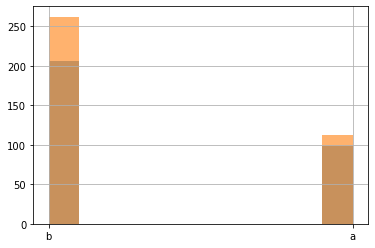

In [10]:
data_grouped['1'].hist(alpha=0.6)

---
**2**

In [11]:
data['2'].value_counts()

?        12
22.67     9
23.58     6
18.83     6
22.50     6
         ..
56.50     1
37.58     1
59.67     1
52.83     1
50.75     1
Name: 2, Length: 346, dtype: int64

In [12]:
data['2'].unique()

array(['30.83', '58.67', '24.50', '27.83', '20.17', '32.08', '33.17',
       '22.92', '54.42', '42.50', '22.08', '29.92', '38.25', '48.08',
       '45.83', '36.67', '28.25', '23.25', '21.83', '19.17', '25.00',
       '47.75', '27.42', '41.17', '15.83', '47.00', '56.58', '57.42',
       '42.08', '29.25', '42.00', '49.50', '36.75', '22.58', '27.25',
       '23.00', '27.75', '54.58', '34.17', '28.92', '29.67', '39.58',
       '56.42', '54.33', '41.00', '31.92', '41.50', '23.92', '25.75',
       '26.00', '37.42', '34.92', '34.25', '23.33', '23.17', '44.33',
       '35.17', '43.25', '56.75', '31.67', '23.42', '20.42', '26.67',
       '36.00', '25.50', '19.42', '32.33', '34.83', '38.58', '44.25',
       '44.83', '20.67', '34.08', '21.67', '21.50', '49.58', '27.67',
       '39.83', '?', '37.17', '25.67', '34.00', '49.00', '62.50', '31.42',
       '52.33', '28.75', '28.58', '22.50', '28.50', '37.50', '35.25',
       '18.67', '54.83', '40.92', '19.75', '29.17', '24.58', '33.75',
       '25.42',

In [13]:
# также уберем строки с вопросом
data = data[data['2'] != '?']
data_grouped = data.groupby("Credit")

Преобразуем колонку в вещественный тип.

In [14]:
data['2'] = pd.to_numeric(data['2'])

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 2, dtype: object

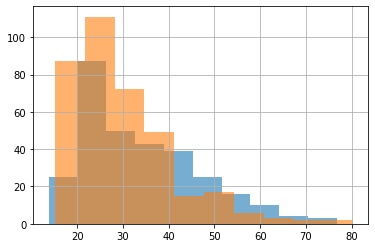

In [15]:
data_grouped['2'].hist(alpha=0.6)

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 2, dtype: object

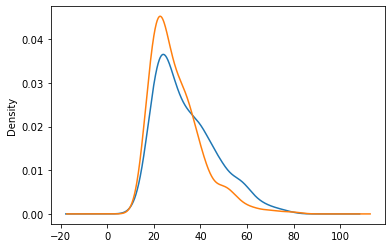

In [16]:
data_grouped['2'].plot(kind='kde')

---
**3**

In [17]:
data['3'].value_counts()

0.000     19
2.500     19
1.500     19
3.000     18
0.750     16
          ..
2.665      1
22.000     1
13.915     1
4.915      1
10.915     1
Name: 3, Length: 215, dtype: int64

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 3, dtype: object

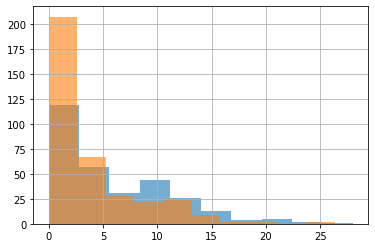

In [18]:
data_grouped['3'].hist(alpha=0.6)

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 3, dtype: object

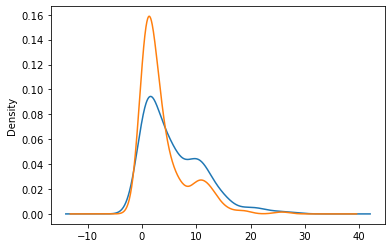

In [19]:
data_grouped['3'].plot(kind='kde')

---
**4**

In [20]:
data['4'].value_counts()

u    503
y    155
?      6
l      2
Name: 4, dtype: int64

In [21]:
# также уберем строки с вопросом
data = data[data['4'] != '?']
data_grouped = data.groupby("Credit")

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 4, dtype: object

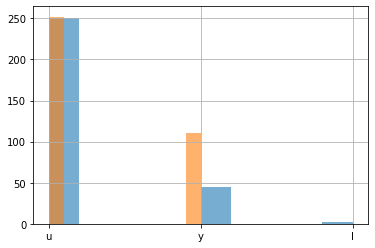

In [22]:
data_grouped['4'].hist(alpha=0.6)

---
**5**

In [23]:
data['5'].value_counts()

g     503
p     155
gg      2
Name: 5, dtype: int64

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 5, dtype: object

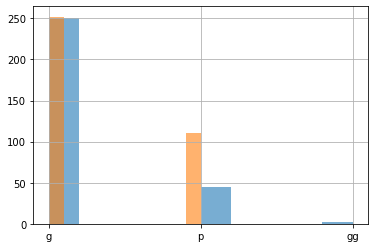

In [24]:
data_grouped['5'].hist(alpha=0.6)

---
**6**

In [25]:
data['6'].value_counts()

c     134
q      76
w      63
i      56
aa     52
ff     51
k      49
cc     40
m      38
x      36
d      27
e      24
j      10
r       3
?       1
Name: 6, dtype: int64

In [26]:
# также уберем строки с вопросом
data = data[data['6'] != '?']
data_grouped = data.groupby("Credit")

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 6, dtype: object

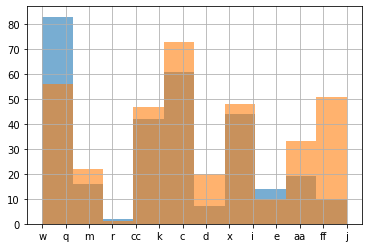

In [27]:
data_grouped['6'].hist(alpha=0.6)

---
**7**

In [28]:
data['7'].value_counts()

v     384
h     137
ff     55
bb     55
j       8
z       8
dd      6
n       4
o       2
Name: 7, dtype: int64

In [29]:
# также уберем строки с вопросом
data = data[data['6'] != '?']
data_grouped = data.groupby("Credit")

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 7, dtype: object

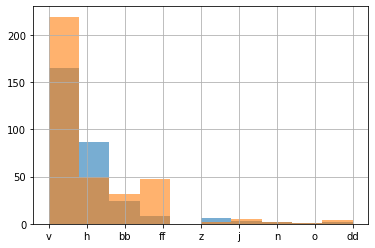

In [30]:
data_grouped['7'].hist(alpha=0.6)

---
**8**

In [31]:
data['8'].unique()

array([ 1.25 ,  3.04 ,  1.5  ,  3.75 ,  1.71 ,  2.5  ,  6.5  ,  0.04 ,
        3.96 ,  3.165,  2.165,  4.335,  1.   ,  5.   ,  0.25 ,  0.96 ,
        3.17 ,  0.665,  0.75 ,  0.835,  7.875,  3.085,  0.5  ,  5.165,
       15.   ,  7.   ,  5.04 ,  7.96 ,  7.585,  0.415,  2.   ,  1.835,
       14.415,  4.5  ,  5.335,  8.625, 28.5  ,  2.625,  0.125,  6.04 ,
        3.5  ,  0.165,  0.875,  1.75 ,  0.   ,  7.415,  0.085,  5.75 ,
        6.   ,  3.   ,  1.585,  4.29 ,  1.54 ,  1.46 ,  1.625, 12.5  ,
       13.5  , 10.75 ,  0.375,  0.585,  0.455,  4.   ,  9.46 ,  2.25 ,
       10.   ,  0.795,  1.375,  1.29 , 11.5  ,  6.29 , 14.   ,  0.335,
        1.21 ,  7.375,  8.5  ,  7.5  ,  3.25 , 13.   ,  5.5  ,  4.25 ,
        0.625,  5.085,  2.75 ,  2.375,  8.   ,  1.085,  2.54 ,  4.165,
        1.665, 11.   ,  9.   ,  1.335,  1.415,  1.96 ,  2.585,  5.125,
       15.5  ,  0.71 ,  5.665, 18.   ,  5.25 ,  8.665,  2.29 , 20.   ,
        2.46 , 13.875,  2.085,  4.58 ,  2.71 ,  2.04 ,  0.29 ,  0.46 ,
      

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 8, dtype: object

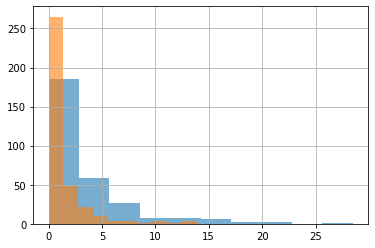

In [32]:
data_grouped['8'].hist(alpha=0.6)

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 8, dtype: object

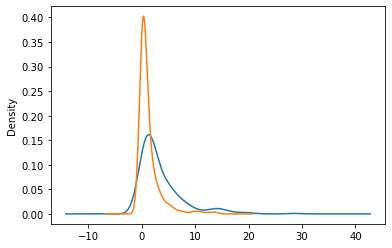

In [33]:
data_grouped['8'].plot(kind='kde')

---
**9**

In [34]:
data['9'].value_counts()

t    352
f    307
Name: 9, dtype: int64

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 9, dtype: object

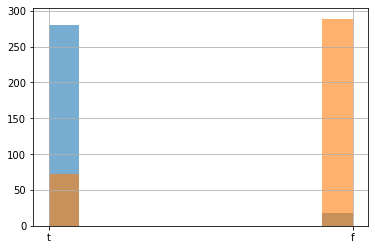

In [35]:
data_grouped['9'].hist(alpha=0.6)

---
**10**

In [36]:
data['10'].value_counts()

f    369
t    290
Name: 10, dtype: int64

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 10, dtype: object

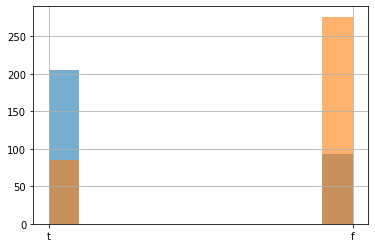

In [37]:
data_grouped['10'].hist(alpha=0.6)

---
**11**

In [38]:
data['11'].unique()

array([ 1,  6,  0,  5,  7, 10,  3, 17,  2,  9,  8, 15, 11, 12, 40, 23,  4,
       20, 67, 14, 16, 13, 19])

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 11, dtype: object

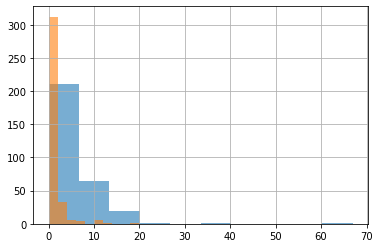

In [39]:
data_grouped['11'].hist(alpha=0.6)

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 11, dtype: object

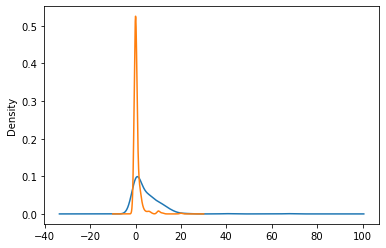

In [40]:
data_grouped['11'].plot(kind='kde')

---
**12**

In [41]:
data['12'].value_counts()

f    355
t    304
Name: 12, dtype: int64

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 12, dtype: object

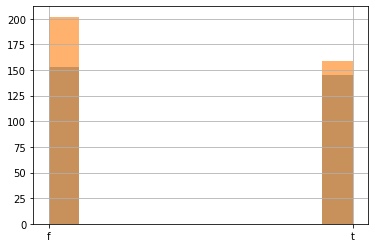

In [42]:
data_grouped['12'].hist(alpha=0.6)

---
**13**

In [43]:
data['13'].value_counts()

g    604
s     53
p      2
Name: 13, dtype: int64

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 13, dtype: object

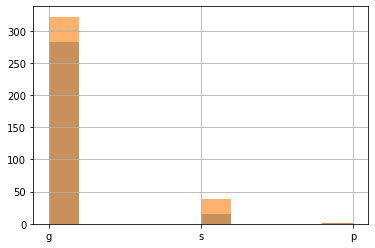

In [44]:
data_grouped['13'].hist(alpha=0.6)

---
**14**

In [45]:
data['14'].unique()

array(['00202', '00043', '00280', '00100', '00120', '00360', '00164',
       '00080', '00180', '00052', '00128', '00260', '00000', '00320',
       '00396', '00096', '00200', '00300', '00145', '00500', '00168',
       '00434', '00583', '00030', '00240', '00070', '00455', '00311',
       '00216', '00491', '00400', '00239', '00160', '00711', '00250',
       '00520', '00515', '00420', '?', '00980', '00443', '00140', '00094',
       '00368', '00288', '00188', '00112', '00171', '00268', '00167',
       '00075', '00152', '00176', '00329', '00212', '00410', '00274',
       '00375', '00408', '00350', '00204', '00040', '00181', '00399',
       '00440', '00093', '00060', '00395', '00393', '00021', '00029',
       '00102', '00431', '00370', '00024', '00020', '00129', '00510',
       '00195', '00144', '00380', '00049', '00050', '00381', '00150',
       '00117', '00056', '00211', '00230', '00156', '00022', '00228',
       '00519', '00253', '00487', '00220', '00088', '00121', '00470',
       '00136',

In [46]:
# также уберем строки с вопросом
data = data[data['14'] != '?']
data_grouped = data.groupby("Credit")

Преобразуем колонку в вещественный тип.

In [47]:
data['14'] = pd.to_numeric(data['14'])

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 14, dtype: object

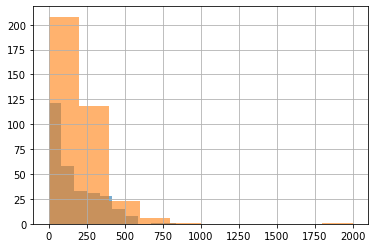

In [48]:
data_grouped['14'].hist(alpha=0.6)

Credit
+    AxesSubplot(0.125,0.125;0.775x0.755)
-    AxesSubplot(0.125,0.125;0.775x0.755)
Name: 14, dtype: object

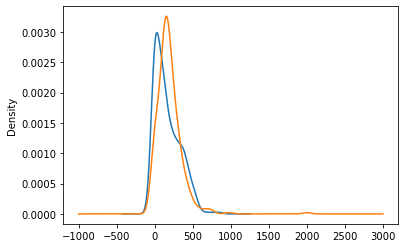

In [49]:
data_grouped['14'].plot(kind='kde')

---
**Credit**

In [50]:
data['Credit'].unique()

array(['+', '-'], dtype=object)

Заменим положительные результаты на 1, отрицательные на 0.

In [51]:
data.loc[data['Credit'] == '+', 'Credit'] = 1
data.loc[data['Credit'] == '-', 'Credit'] = 0

In [52]:
data['Credit'].unique()

array([1, 0], dtype=object)

In [53]:
data['Credit'] = data['Credit'].astype(int)

## Часть 2. Preprocessing & Feature Engineering

Так как мы убирали некоторые строки из нашего датасета, необходимо обновить индекс

In [54]:
data.reset_index(drop=True, inplace=True)
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Credit
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,1


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       653 non-null    object 
 1   2       653 non-null    float64
 2   3       653 non-null    float64
 3   4       653 non-null    object 
 4   5       653 non-null    object 
 5   6       653 non-null    object 
 6   7       653 non-null    object 
 7   8       653 non-null    float64
 8   9       653 non-null    object 
 9   10      653 non-null    object 
 10  11      653 non-null    int64  
 11  12      653 non-null    object 
 12  13      653 non-null    object 
 13  14      653 non-null    int64  
 14  15      653 non-null    int64  
 15  Credit  653 non-null    int64  
dtypes: float64(3), int64(4), object(9)
memory usage: 81.8+ KB


Переведем категориальные переменные в уникальные лейблы, используя LabelEncoder и OneHotEncoder.

In [56]:
original_data = data.copy()

In [57]:
original_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Credit
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260,0,0
649,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200,394,0
650,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200,1,0
651,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280,750,0


In [58]:
data = original_data.copy()

In [59]:
data = pd.concat([
    data, 
    pd.get_dummies(data['1'], prefix='1_')],
    axis=1
)
data.drop(['1'], inplace=True, axis=1)

In [60]:
data = pd.concat([
    data, 
    pd.get_dummies(data['4'], prefix='4_')],
    axis=1
)
data.drop(['4'], inplace=True, axis=1)

In [61]:
data = pd.concat([
    data, 
    pd.get_dummies(data['5'], prefix='5_')],
    axis=1
)
data.drop(['5'], inplace=True, axis=1)

In [62]:
data = pd.concat([
    data, 
    pd.get_dummies(data['9'], prefix='9_')],
    axis=1
)
data.drop(['9'], inplace=True, axis=1)

In [63]:
data = pd.concat([
    data, 
    pd.get_dummies(data['10'], prefix='10_')],
    axis=1
)
data.drop(['10'], inplace=True, axis=1)

In [64]:
data = pd.concat([
    data, 
    pd.get_dummies(data['12'], prefix='12_')],
    axis=1
)
data.drop(['12'], inplace=True, axis=1)

In [65]:
data = pd.concat([
    data, 
    pd.get_dummies(data['13'], prefix='13_')],
    axis=1
)
data.drop(['13'], inplace=True, axis=1)

In [66]:
label_encoder = LabelEncoder()
data['6_encoded'] = label_encoder.fit_transform(data['6'])
data['7_encoded'] = label_encoder.fit_transform(data['7'])
data.drop(['6', '7'], inplace=True, axis=1)

In [67]:
data

,2,3,8,11,14,15,Credit,1__a,1__b,4__l,...,9__t,10__f,10__t,12__f,12__t,13__g,13__p,13__s,6_encoded,7_encoded
0,30.83,0.000,1.25,1,202,0,1,0,1,0,...,1,0,1,1,0,1,0,0,12,7
1,58.67,4.460,3.04,6,43,560,1,1,0,0,...,1,0,1,1,0,1,0,0,10,3
2,24.50,0.500,1.50,0,280,824,1,1,0,0,...,1,1,0,1,0,1,0,0,10,3
3,27.83,1.540,3.75,5,100,3,1,0,1,0,...,1,0,1,0,1,1,0,0,12,7
4,20.17,5.625,1.71,0,120,0,1,0,1,0,...,1,1,0,1,0,0,0,1,12,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648,21.08,10.085,1.25,0,260,0,0,0,1,0,...,0,1,0,1,0,1,0,0,4,3
649,22.67,0.750,2.00,2,200,394,0,1,0,0,...,0,0,1,0,1,1,0,0,1,7
650,25.25,13.500,2.00,1,200,1,0,1,0,0,...,0,0,1,0,1,1,0,0,5,2
651,17.92,0.205,0.04,0,280,750,0,0,1,0,...,0,1,0,1,0,1,0,0,0,7


## Часть 3. Моделирование

### 3.1 Подготовка данных

Сохраним в $X$ все колонки признаки, а в $y$ $-$ целевую переменную.

In [68]:
X = data.drop('Credit', axis=1)
y = data['Credit']

X.shape, y.shape

((653, 25), (653,))

Разобьем данные на тренировочный и тестовый наборы.

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((457, 25), (196, 25), (457,), (196,))

Можем заметить, что значения некоторых признаков имеют разный масштаб. Приведем к одному масштабу непрерывные признаки.

In [71]:
TO_SCALE = ['2', '3', '8', '14', '15']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
X_train_scaled[TO_SCALE] = scaler.fit_transform(X_train[TO_SCALE])
X_test_scaled[TO_SCALE] = scaler.transform(X_test[TO_SCALE])

### 3.2 Построение моделей градиентного бустинга без настройки гиперпараметров

Создадим функцию для подсчета оценок классификации.

In [72]:
score_table = pd.DataFrame({"score":["Accuracy", "Precision", "Recall", "F1-score", "AUC"]})
score_table.set_index("score")

""
score
Accuracy
Precision
Recall
F1-score
AUC


In [73]:
def calculate_score(classifier, y_expected, y_predicted, y_predicted_proba):
    accuracy = accuracy_score(y_predicted, y_expected)
    print("Accuracy:  {:.3f}".format(accuracy))

    precision = precision_score(y_predicted, y_expected)
    print("Precision: {:.3f}".format(precision))

    recall = recall_score(y_predicted, y_expected)
    print("Recall:    {:.3f}".format(recall))

    f1 = f1_score(y_predicted, y_expected)
    print("F1-score:  {:.3f}".format(f1))
    
    auc = roc_auc_score(y_expected, y_predicted_proba)
    print("AUC:       {:.3f}".format(auc))
    
    score_table[classifier] = [accuracy, precision, recall, f1, auc]

#### `GradientBoostingClassifier`

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_scaled, y_train)
y_pred = gb_classifier.predict(X_test_scaled)
y_pred_proba = gb_classifier.predict_proba(X_test_scaled)
calculate_score('GradientBoostingClassifier', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.847
Precision: 0.837
Recall:    0.818
F1-score:  0.828
AUC:       0.941


#### `XGBoost`

In [75]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train_scaled, y_train)
y_pred = xgb_classifier.predict(X_test_scaled)
y_pred_proba = xgb_classifier.predict_proba(X_test_scaled)
calculate_score('XGBClassifier', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.847
Precision: 0.826
Recall:    0.826
F1-score:  0.826
AUC:       0.928


#### `CatBoost`

In [76]:
from catboost import CatBoostClassifier

catboost_classifier = CatBoostClassifier(silent=True)
catboost_classifier.fit(X_train_scaled, y_train)
y_pred = catboost_classifier.predict(X_test_scaled)
y_pred_proba = catboost_classifier.predict_proba(X_test_scaled)
calculate_score('CatBoostClassifier', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.872
Precision: 0.884
Recall:    0.835
F1-score:  0.859
AUC:       0.941


 #### `LGBMClassifier`

In [77]:
from lightgbm import LGBMClassifier

lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train_scaled, y_train)
y_pred = lgbm_classifier.predict(X_test_scaled)
y_pred_proba = lgbm_classifier.predict_proba(X_test_scaled)
calculate_score('LGBMClassifier', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.857
Precision: 0.826
Recall:    0.845
F1-score:  0.835
AUC:       0.936


#### Результаты

In [78]:
score_table

,score,GradientBoostingClassifier,XGBClassifier,CatBoostClassifier,LGBMClassifier
0,Accuracy,0.846939,0.846939,0.872449,0.857143
1,Precision,0.837209,0.825581,0.883721,0.825581
2,Recall,0.818182,0.825581,0.835165,0.845238
3,F1-score,0.827586,0.825581,0.858757,0.835294
4,AUC,0.940909,0.927590,0.941226,0.936258


На данный момент наибольшую точность прогнозирования дает `CatBoostClassifier`.

### 3.3 Построение моделей градиентного бустинга с настройкой гиперпараметров

#### `GradientBoostingClassifier`.

In [79]:
%%time

parameters = {
    "n_estimators": stats.randint(10, 1000),
    "learning_rate": stats.uniform(0.01, 1),
    "subsample": stats.uniform(0.5, 1.0),

    "max_depth": stats.randint(3, 10),
    "min_samples_split": stats.randint(3, 20),
    "min_samples_leaf": stats.randint(3, 20)
}

gb_classifier_tuned = RandomizedSearchCV(GradientBoostingClassifier(), parameters, n_iter=100, cv=5, n_jobs=-1)
gb_classifier_tuned.fit(X_train_scaled, y_train)

print(gb_classifier_tuned.score(X_train_scaled, y_train))
print(gb_classifier_tuned.best_params_)

0.986870897155361
{'learning_rate': 0.017512413826403554, 'max_depth': 8, 'min_samples_leaf': 16, 'min_samples_split': 11, 'n_estimators': 540, 'subsample': 0.5387451268199314}
CPU times: user 1.83 s, sys: 46.5 ms, total: 1.88 s
Wall time: 20 s


In [80]:
y_pred = gb_classifier_tuned.predict(X_test_scaled)
y_pred_proba = gb_classifier_tuned.predict_proba(X_test_scaled)
calculate_score('GradientBoostingClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.872
Precision: 0.849
Recall:    0.859
F1-score:  0.854
AUC:       0.939


#### `XGBoost`

In [81]:
%%time

parameters = {
    'n_estimators': stats.randint(10, 1000),
    'learning_rate': stats.uniform(0.01, 1),
    'subsample': stats.uniform(0.5, 1.0),

    'max_depth': stats.randint(3, 10),
    'gamma': stats.uniform (1, 9),
    'min_child_weight' : stats.randint(0, 10),
    'colsample_bytree': stats.uniform(0.5, 1),
    'reg_alpha': stats.randint(0, 1),
    'reg_lambda': stats.uniform(0, 1),
}

xgb_classifier_tuned = RandomizedSearchCV(xgb.XGBClassifier(), parameters, n_iter=100, cv=5, n_jobs=-1)
xgb_classifier_tuned.fit(X_train_scaled, y_train)

print(xgb_classifier_tuned.score(X_train_scaled, y_train))
print(xgb_classifier_tuned.best_params_)

0.9059080962800875
{'colsample_bytree': 0.6716658477091806, 'gamma': 7.272563331126994, 'learning_rate': 0.37486155195298965, 'max_depth': 3, 'min_child_weight': 8, 'n_estimators': 279, 'reg_alpha': 0, 'reg_lambda': 0.03147281268293267, 'subsample': 0.8070580519175499}
CPU times: user 1.2 s, sys: 19.8 ms, total: 1.22 s
Wall time: 4.03 s


In [82]:
y_pred = xgb_classifier_tuned.predict(X_test_scaled)
y_pred_proba = xgb_classifier_tuned.predict_proba(X_test_scaled)
calculate_score('XGBClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.852
Precision: 0.860
Recall:    0.813
F1-score:  0.836
AUC:       0.929


#### `CatBoost`

In [88]:
%%time

parameters = {
    'n_estimators': stats.randint(100, 1000),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.9),

    'depth': stats.randint(3, 13),
    "min_data_in_leaf": stats.randint(1, 10),    
    'l2_leaf_reg': stats.randint(1, 5),
    'random_strength': stats.uniform(0, 3),
    'bagging_temperature': stats.uniform(0.5, 1.0),
    'border_count': [32, 64, 128, 256]
}

catboost_classifier_tuned = RandomizedSearchCV(CatBoostClassifier(silent=True), parameters, 
                                               cv=5, n_jobs=-1)
catboost_classifier_tuned.fit(X_train_scaled, y_train)

print(catboost_classifier_tuned.score(X_train_scaled, y_train))
print(catboost_classifier_tuned.best_params_)

/home/myslovets/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


1.0
{'bagging_temperature': 0.619765537935283, 'border_count': 64, 'depth': 11, 'l2_leaf_reg': 4, 'learning_rate': 0.013819185056281161, 'min_data_in_leaf': 9, 'n_estimators': 597, 'random_strength': 2.193124188043769, 'subsample': 0.7844706207001071}
CPU times: user 13.7 s, sys: 1.46 s, total: 15.1 s
Wall time: 1min 50s


In [89]:
y_pred = catboost_classifier_tuned.predict(X_test_scaled)
y_pred_proba = catboost_classifier_tuned.predict_proba(X_test_scaled)
calculate_score('CatBoostClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.878
Precision: 0.872
Recall:    0.852
F1-score:  0.862
AUC:       0.948


 #### `LGBMClassifier`

In [96]:
%%time

parameters = {
    "n_estimators": stats.randint(10, 100),
    "learning_rate": stats.uniform(0.01, 1),
    "subsample": stats.uniform(0.5, 1.0),
    
    "max_depth": stats.randint(3, 13),
    "num_leaves": stats.randint(1, 50),
    "min_data_in_leaf": stats.randint(1, 100),    
    "max_bin": stats.randint(3, 50),    
    "boosting_type" : ['gbdt', 'dart'],    
    'reg_alpha': stats.randint(0, 4),
    'reg_lambda': stats.uniform(0, 4)
}

lgbm_classifier_tuned = RandomizedSearchCV(LGBMClassifier(), parameters, n_iter=1000,
                                            scoring='accuracy', cv=5, n_jobs=-1)
lgbm_classifier_tuned.fit(X_train_scaled, y_train)

print(lgbm_classifier_tuned.score(X_train_scaled, y_train))
print(lgbm_classifier_tuned.best_params_)

0.949671772428884
{'boosting_type': 'gbdt', 'learning_rate': 0.6693984738299221, 'max_bin': 18, 'max_depth': 12, 'min_data_in_leaf': 70, 'n_estimators': 51, 'num_leaves': 20, 'reg_alpha': 1, 'reg_lambda': 2.731562321276965, 'subsample': 0.8835264810820884}
CPU times: user 2.35 s, sys: 22.4 ms, total: 2.38 s
Wall time: 6.8 s


In [97]:
y_pred = lgbm_classifier_tuned.predict(X_test_scaled)
y_pred_proba = lgbm_classifier_tuned.predict_proba(X_test_scaled)
calculate_score('LGBMClassifier_Tuned', y_test, y_pred, y_pred_proba[:, 1])

Accuracy:  0.857
Precision: 0.849
Recall:    0.830
F1-score:  0.839
AUC:       0.921


#### Результаты

In [98]:
score_table

,score,GradientBoostingClassifier,XGBClassifier,CatBoostClassifier,LGBMClassifier,GradientBoostingClassifier_Tuned,XGBClassifier_Tuned,CatBoostClassifier_Tuned,LGBMClassifier_Tuned
0,Accuracy,0.846939,0.846939,0.872449,0.857143,0.872449,0.852041,0.877551,0.857143
1,Precision,0.837209,0.825581,0.883721,0.825581,0.848837,0.860465,0.872093,0.848837
2,Recall,0.818182,0.825581,0.835165,0.845238,0.858824,0.813187,0.852273,0.829545
3,F1-score,0.827586,0.825581,0.858757,0.835294,0.853801,0.836158,0.862069,0.839080
4,AUC,0.940909,0.927590,0.941226,0.936258,0.939323,0.928594,0.948097,0.920719
